# EE4312 Lab 2 *Denoising Autoencoder* (Solutions)
Due Date: 30 Mar 2025 (W10 Sun), 23:59

---
# 1 &emsp; Introduction
This lab implements an autoencoder for denoising MNIST images. The denoising task is a regression problem with the structure of an autoencoder &mdash; the sizes of the input and output layer correspond to the input and output dimensions, while the size of the hidden layer correspond to the smaller latent space representation. An autoencoder typically has an **odd** number of hidden layers.

The code in this lab is similar to the classification task in project 1. Below are sample outputs from this lab.


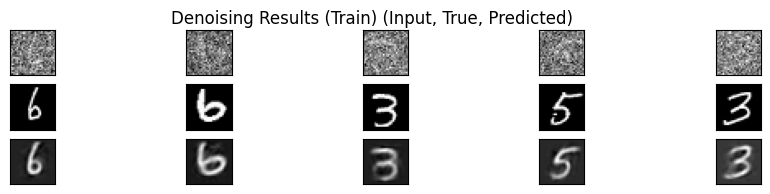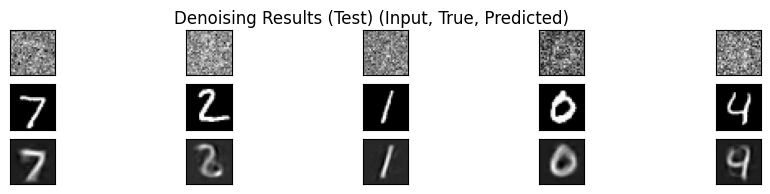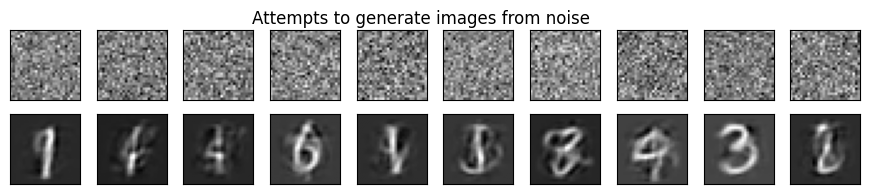

## 1.1 &emsp; Initialization
1. Replace the string in `matric_numbers` with your matric number.
2. Run the code block (`Ctrl+Enter`).

l2_x_train Shape (num, dim1, dim2,): (48000, 28, 28)
l2_y_train Shape (num,): (48000, 28, 28)
l2_x_test Shape (num, dim1, dim2,): (10000, 28, 28)
l2_y_test Shape (num,): (10000, 28, 28)


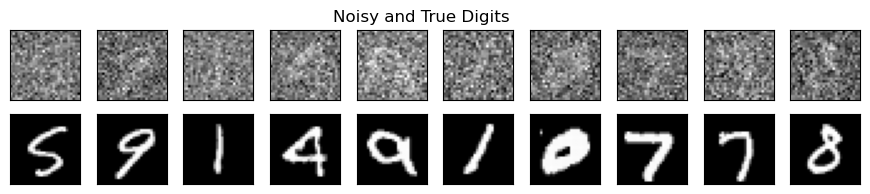

In [1]:
matric_numbers = ['A0233403W']

######### Import libraries ###################
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import keras
import cv2
import os
import shutil

########## Code to make training reproducible ##########
def makeSeed(matric_numbers):
  seed = 0;
  for i in range(len(matric_numbers)):
    seed += int(''.join(filter(str.isdigit, matric_numbers[i])))
  return seed

SEED = makeSeed(matric_numbers)

def makeReproducible():
  tf.keras.utils.set_random_seed(SEED)
  tf.config.experimental.enable_op_determinism()

########### Create Folders to store trained data #############
L2_FOLDER = 'lab2'
shutil.rmtree(L2_FOLDER, ignore_errors=True)
os.makedirs(L2_FOLDER, exist_ok=True)
# !rm -rf $L2_FOLDER # this is not a valid python script, used only in colab
# !mkdir -p $L2_FOLDER # this is not a valid python script, used only in colab

###### Variables to be initialized later, placed here for clarity ##########
l2_model = None
l2_expt_name = ''
l2_nums_hidden = []
l2_learning_rate = 0
l2_epochs = 0
l2_batch_size = 0
l2_elapsed = 0
l2_history = None
l2_x_train = []
l2_y_train = [] # the true y over the domain of x_test
l2_x_test = [] # the x data, that has a smaller domain than x_test
l2_y_test = [] # the noisy y over the domain of x_train
l2_y_pred_test = [] # to fill in later
l2_y_pred_train = []
l2_layer_flatten = None
l2_layer_norm = None
l2_layer_reshape = None

##### Initialize the variables ########
def initTask():
  (l2_x_train, l2_y_train), (l2_x_test, l2_y_test) = keras.datasets.mnist.load_data() # load the mnist dataset

  # store the chosen images 
  idx = np.random.randint(l2_y_train.shape[0], size=int(l2_y_train.shape[0]*0.8)) # 80% of the data
  l2_y_train = l2_x_train[idx] # store the true y
  l2_x_train = l2_y_train + np.random.normal(0, 255, l2_y_train.shape)  # store the noisy y
  l2_y_test = l2_x_test  # store the true y
  l2_x_test = l2_y_test + np.random.normal(0, 255, l2_y_test.shape) # store the noisy y
  return l2_x_train, l2_y_train, l2_x_test, l2_y_test 

##### Plot the Task #######
def plotTask():
  fig, axes = plt.subplots(ncols=10, nrows=2, figsize=(11,2))
  fig.suptitle('Noisy and True Digits')
  for i in range(10):
    idx = np.random.randint(np.min((l2_y_train.shape[0], 100)))
    axes[0, i].imshow(l2_x_train[idx], cmap='gray')
    axes[1, i].imshow(l2_y_train[idx], cmap='gray')
    for j in range(2):
      axes[j,i].set_xticks([])
      axes[j,i].set_yticks([])

  print(f'l2_x_train Shape (num, dim1, dim2,): {l2_x_train.shape}')
  print(f'l2_y_train Shape (num,): {l2_y_train.shape}')
  print(f'l2_x_test Shape (num, dim1, dim2,): {l2_x_test.shape}')
  print(f'l2_y_test Shape (num,): {l2_y_test.shape}')


##### Run the functions ##########
makeReproducible() # call this everytime to 'reset' the random number generator and make subsequent random calls reproducible.
l2_x_train, l2_y_train, l2_x_test, l2_y_test = initTask()
plotTask()

---

# 2 &emsp; Coding the Autoencoder Model

## 2.1 &emsp; Preprocessing and Reshaping
For the preprocessing steps.
  1. Flatten an image input from a $28\times28$ matrix into a $784 \times 1$ feature vector.
  ```python
  l2_layer_flatten = keras.layers.Flatten()
  x_train_flat = l2_layer_flatten(l2_x_train) # obtain a n times 784 vector containing n flatten images, where n is the number of images in the training samples l2_x_train.
  ```
  2. Perform unit normalization (0 mean, 1 variance) over every feature for every image in the training dataset, to calculate a total of 784 means and 784 variances.
  ```python
  l2_layer_norm = keras.layers.Normalization()
  l2_layer_norm.???(x_train_flat) # to calculate and remember every feature's mean and variance in the layer BEFORE training.
  ```
  3. The reshaping layer is applied **after** the output layer to re-obtain the $28 \times 28$ image from the output layer's 784 neurons.
  ```python
  l2_layer_reshape = keras.layers.Reshape(???)
  ```

  4. The flatten layer `l2_layer_flatten`, the normalization layer `l2_layer_norm` are returned, and the final reshape layer `l2_layer_reshape` are returned. **Run** the code block to register the changes.

In [2]:
def preprocess():
  ######## Flatten Layer ########
  # (1)
  l2_layer_flatten = keras.layers.Flatten() # flatten the input
  x_train_flat = l2_layer_flatten(l2_x_train) # flatten the x_train

  ######## Normalization Layer ########
  # (2)
  l2_layer_norm = keras.layers.Normalization() # normalize the input
  l2_layer_norm.adapt(x_train_flat) #adapt the normalization layer to the x_train
  #this way, we can find the mean and variance of the x_train and normalize the x_test with the same mean and variance
  ######## Output's Reshape Layer ########
  # (3)
  l2_layer_reshape = keras.layers.Reshape((28,28)) # reshape the output to the original shape
  return l2_layer_flatten, l2_layer_norm, l2_layer_reshape

## 2.2 &emsp; Build Autoencoder Model

Specify the design of the neural network in `l2_model`, which will be returned by the function `buildModel()`.

1. **Initialize the input and output layers**.
  ```python
  input_layer = keras.Input(shape=??)
  output_layer = keras.layers.Dense(??, activation=????)
  ```

2. **Initialize hidden layers**. This step is the same as project 1, which is that the hidden layers are dynamically generated. If `l2_nums_hidden` is `[128]`, there is 1 hidden layer with 128 neurons. If it is `[128,64,128]`, there is 128 neurons in the first hidden layer, 64 neurons in the second hidden layer, and 128 neurons in the third hidden layer.

3. **Link the layers** by calling the layer variables (i.e. using `()`) with their previous layer. Remember to use `l2_layer_flat`, `l2_layer_norm` and `l2_layer_reshape`. Linking is done with the following example:
  ```python
  layer2 = layer2(layer1(input_layer))
  # ...
  last_layer = l2_layer_reshape(l2_layer_output)
  ```

4. **Initialize the model** `l2_model` with the linked layers:
  ```python
  l2_model = keras.Model(inputs=[input_layer], outputs=[???], name='Autoencoder')
  # to determine based on preprocess
  ```

5. **Compile the model** with the selected loss and optimizer:
  ```python
  sgd = keras.optimizers.SGD(learning_rate=l2_learning_rate)
  l2_model.compile(loss='??', optimizer=sgd) # ?? is the name of the loss used in regression.
  ```
  
6. Next, print a summary of the model to the output using
  ```python
  l2_model.summary()
  ```

7. The model is then returned by the function. **Run** the cell block to register the function into the workspace.

In [3]:
def buildModel():
  ###### Specify layers #####
  # (1), (2)
  input_layer = keras.layers.Input(shape=(28,28)) #creating the input layer
  output_layer = keras.layers.Dense((28*28), activation='linear') #creating the output layer
  hidden_layers = l2_layer_norm(l2_layer_flatten(input_layer))
  for num_hidden in l2_nums_hidden:
    hidden_layers = keras.layers.Dense(num_hidden, activation='relu')(hidden_layers)
  ###### Link the layers #####
  # (3)
  output = l2_layer_reshape(output_layer(hidden_layers)) # link the layers
  ###### Initialize model #####
  # (4)
  l2_model = keras.models.Model(inputs=[input_layer], outputs=[output], name="Autoencoder") # create the model
  ###### Compile model #####
  # (5)
  sgd = keras.optimizers.SGD(learning_rate=l2_learning_rate) # create the optimizer
  l2_model.compile(loss='mse', optimizer=sgd) # compile the model
  ###### Summarize #####
  # (6)
  l2_model.summary() # print the summary of the model

  print(f'----------------------------------')
  return l2_model

## 2.3 &emsp; Function to Train Model

1. In the function, the `.fit()` method is used to train the model `l2_model`:
```python
l2_history = l2_model.fit(???, # the x samples used for training.
                        ???, # the y samples used for training.
                        shuffle=True,
                        batch_size=???, # the batch size.
                        epochs=???, # the number of epochs.
                        validation_split=0,
                        verbose=1,
                        ) # this is a single line-command split over multiple lines for readability.
```
  The code above requires:
  - The input train samples stored in `l2_x_train`.
  - The output train samples stored in `l2_y_train`.
  - The batch size stored in `l2_batch_size`.
  - The number of epochs to stored in `l2_epochs`.

  `l2_history` stores information about the training. `l2_elapsed` is the time taken to train the model in seconds. `l2_model` will contain the trained weights and can be used to predict an input layer. The three variables are returned by the function.

2. **Run** the code block to register the function and fix any errors.

In [4]:
def trainModel():

  ########### Train the Model #########
  print(f'    Experiment: {l2_expt_name}\nHidden Neurons: {l2_nums_hidden}\n Learning Rate: {l2_learning_rate}\n        Epochs: {l2_epochs}\n    Batch Size: {l2_batch_size}')
  l2_elapsed = time.time()

  # (1)
  l2_history = l2_model.fit(
    l2_x_train, 
    l2_y_train,
    batch_size=l2_batch_size, # batch size
    epochs=l2_epochs, # number of epochs
    validation_split=0, # no validation set
    verbose=1 # print the progress
  )

  l2_elapsed = time.time() - l2_elapsed

  ########### Save the model ###########
  l2_model.save(f'{L2_FOLDER}/{l2_expt_name}.keras')
  print(f'Trained Model saved to {L2_FOLDER}/{l2_expt_name}.keras')

  return l2_model, l2_history, l2_elapsed

## 2.4 &emsp; Function to Predict Train and Test Samples
The method `.predict()` is used to predict the output from the trained model `l2_model`:
```python
  ?? = l2_model.predict(????) # ?? is the predicted output. ???? is the input used to predict the output.
```
1. Predict the denoised output `l2_y_pred_test` from the test images in `l2_x_test`.
2. Predict the denoised output `l2_y_pred_train` from the test images in `l2_x_train`.
3. **Run** the code block to register the function and fix any errors.


In [5]:
def predictModel():
  # (1)
  l2_y_pred_test = l2_model.predict(l2_x_test) # predict the x_test
  # (2)
  l2_y_pred_train = l2_model.predict(l2_x_train) # predict the x_train

  return l2_y_pred_train, l2_y_pred_test

## 2.5 &emsp; Function to Analyze Trained Model

This function outputs the statistics about the model and saves the results.

1. Find `test_loss`, which is the loss between `l2_y_pred_test` with `l2_y_test`.
2. Find `train_loss`, which is the loss between `l2_y_pred_train` with `l2_y_train`.

In [6]:
def analyzeModel():
  ##### Find the accuracy of the model ###
  # (1)
  loss = keras.losses.MeanSquaredError() # find the loss
  test_loss = loss(l2_y_test, l2_y_pred_test).numpy() # find the loss of the test set
  # (2)
  train_loss = loss(l2_y_train, l2_y_pred_train).numpy() # find the loss of the train set
  #### Write to text file ####
  l2_history_loss = l2_history.history['loss']
  tmp = open(f'{L2_FOLDER}/{l2_expt_name}.txt', 'w')
  out = ''
  out += f'Experiment\t{l2_expt_name}\n'
  out += f'Hidden Neurons\t{l2_nums_hidden}\n'
  out += f'Learning Rate\t{l2_learning_rate}\n'
  out += f'Epochs\t{l2_epochs}\n'
  out += f'Batch\t{l2_batch_size}\n'
  out += f'Elapsed(s)\t{l2_elapsed}\n'
  for i in range(1, 11):
    out += f'Moving Average Loss ({i}0% Epoch)\t{l2_history_loss[int(0.1 * i * len(l2_history_loss) - 1)]}\n'
  # insert any metric you want to monitor
  out += f'Train Loss\t{train_loss}\n'
  out += f'Test Loss\t{test_loss}\n'

  tmp.write(out)
  tmp.close()
  print(out)

  ##### Display results (train) #####
  fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(11,2))
  fig.suptitle('Denoising Results (Train) (Input, True, Predicted)')

  for i in range(5):
    axes[0,i].imshow(l2_x_train[i, :, :], cmap='gray')
    axes[1,i].imshow(l2_y_train[i, :, :], cmap='gray')
    axes[2,i].imshow(l2_y_pred_train[i, :, :], cmap='gray')
    for j in range(3):
      axes[j,i].set_xticks([])
      axes[j,i].set_yticks([])
  plt.savefig(f'{L2_FOLDER}/{l2_expt_name}_results_train.png', bbox_inches='tight')


  ##### Display results (test) #####
  fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(11,2))
  fig.suptitle('Denoising Results (Test) (Input, True, Predicted)')

  for i in range(5):
    axes[0,i].imshow(l2_x_test[i, :, :], cmap='gray')
    axes[1,i].imshow(l2_y_test[i, :, :], cmap='gray')
    axes[2,i].imshow(l2_y_pred_test[i, :, :], cmap='gray')
    for j in range(3):
      axes[j,i].set_xticks([])
      axes[j,i].set_yticks([])
  plt.savefig(f'{L2_FOLDER}/{l2_expt_name}_results_test.png', bbox_inches='tight')

  ##### apply and display results from random noisy input #####
  fig, axes = plt.subplots(ncols=10, nrows=2, figsize=(11,2))
  fig.suptitle('Attempts to generate images from noise')

  for i in range(10):
    img = np.random.normal(0, 10, (2, 4))
    img = cv2.resize(img, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
    img = img + np.random.normal(0, 300, (28, 28))
    img = np.reshape(img, (1, 28, 28))

    img_denoise = l2_model.predict(img)

    axes[0, i].imshow(img[0, :, :], cmap='gray')
    axes[1, i].imshow(img_denoise[0, :, :], cmap='gray')

    for j in range(2):
      axes[j,i].set_xticks([])
      axes[j,i].set_yticks([])
  plt.savefig(f'{L2_FOLDER}/{l2_expt_name}_noise.png', bbox_inches='tight')

# 3 &emsp; Experiments

1. Test your code and fix any errors.
2. Once all errors are fixed, you may adjust the `experiments` list to run multiple experiments and observe the effects of adjusting all hyperparameters **except for the number of epochs**.
3. During submission,
  - Keep the **best experiment** in this block.
  - Ensure that the **output** of this block corresponds to the best experiment.

====================== START OF EXPT final ====================================
Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 normalization (Normalizatio  (None, 784)              1569      
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 128)               100480    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 128) 

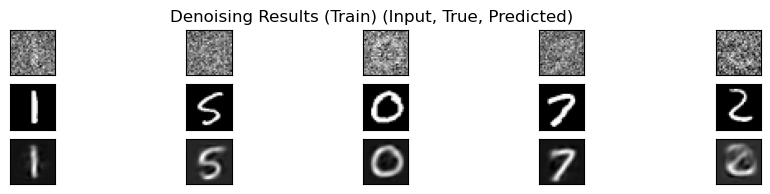

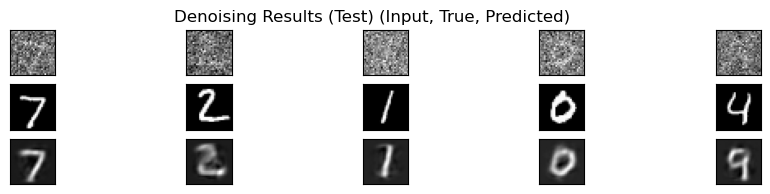

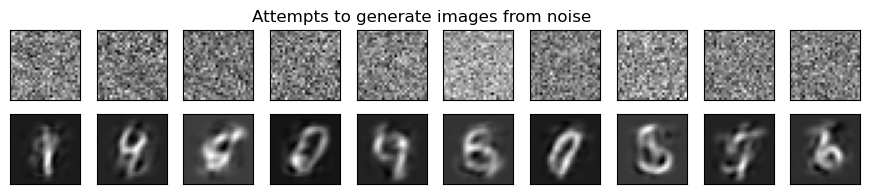

In [7]:
experiments = [
  ('final', [128, 64,128], 0.001, 20, 32),
  # ('a', [64], 0.005, 20, 16),
  # ('3', [128, 64,128], 0.001, 20, 16), #testing with more hidden layers
  # ('3_lowlr', [128, 64,128], 0.0001, 20, 16), #testing with more hidden layers
  # ('3_highlr', [128, 64,128], 0.01, 20, 16), #testing with more hidden layers
  # ('3_lowbr', [128, 64,128], 0.001, 20, 8), #testing with more hidden layers
  # ('3_highbr', [128, 64,128], 0.001, 20, 32), #testing with more hidden layers
  
  # ('3_lowHN', [64, 32, 64], 0.001, 20, 16), #testing with more hidden layers
  # ('3_lowerHN', [32, 16, 32], 0.001, 20, 16), #testing with more hidden layers
  # ('3_highHN', [256, 128, 256], 0.001, 20, 16), #testing with more hidden layers
  # ('3_a', [128, 64, 128], 0.005, 20, 32), #testing with more hidden layers
    # ('test', [64,32,16,32,64], 0.001, 20, 32), #testing with more hidden layers
    # ('test1', [64,32,16,32,64], 0.001, 20, 16), #testing with more hidden layers
    # ('test2', [200,100,50,200,100,50], 0.001, 20, 32), #testing with more hidden layers
    # ('test3', [200,100,50,200,100,50], 0.001, 20, 16), #testing with more hidden layers
    # ('test4', [140,70,35,70,140], 0.001, 20, 8), #testing with more hidden layers
  
  
  # ('4', [256, 128, 64, 128, 256], 0.001, 20, 16), #testing with more hidden layers
  # ('4_lowlr', [256, 128, 64, 128, 256], 0.0001, 20, 16), #testing with more hidden layers
  # ('4_highlr', [256, 128, 64, 128, 256], 0.01, 20, 16), #testing with more hidden layers
  # ('4_lowbr', [256, 128, 64, 128, 256], 0.001, 20, 8), #testing with more hidden layers
  # ('4_highbr', [256, 128, 64, 128, 256], 0.001, 20, 32), #testing with more hidden layers
  
  # ('5', [512, 256, 128, 64, 128, 256, 512], 0.001, 20, 16), #testing with more hidden layers
  # ('5_lowlr', [512, 256, 128, 64, 128, 256, 512], 0.0001, 20, 16), #testing with more hidden layers
  # ('5_highlr', [512, 256, 128, 64, 128, 256, 512], 0.01, 20, 16), #testing with more hidden layers
  # ('5_lowbr', [512, 256, 128, 64, 128, 256, 512], 0.001, 20, 8), #testing with more hidden layers
  # ('5_highbr', [512, 256, 128, 64, 128, 256, 512], 0.001, 20, 32), #testing with more hidden layers
]


l2_layer_flatten, l2_layer_norm, l2_layer_reshape = preprocess()

for expt in experiments:
  l2_expt_name = expt[0]
  l2_nums_hidden = expt[1]
  l2_learning_rate = expt[2]
  l2_epochs = expt[3]
  l2_batch_size = expt[4]

  print(f'====================== START OF EXPT {l2_expt_name} ====================================')

  makeReproducible()
  l2_model = buildModel()

  makeReproducible()
  l2_model, l2_history, l2_elapsed = trainModel()

  l2_y_pred_train, l2_y_pred_test = predictModel()

  analyzeModel()

  print(f'====================== END OF EXPT {l2_expt_name} ======================================')

---
# 4 &emsp; Download Data
Run the following code to download all figures and data if required.

In [8]:
# from google.colab import files
# !rm -rf data.zip
# !zip -r data.zip data
# files.download('data.zip')
#download the data folder
os.system(f'zip -r data.zip {L2_FOLDER}')
print(f'Zip file saved to data.zip')
# #download
# #remove the data folder
# shutil.rmtree(L2_FOLDER, ignore_errors=True)
# print(f'Folder {L2_FOLDER} removed')

Zip file saved to data.zip


---
# 5 &emsp; Submission


## 5.1 &emsp; Requirements

1. Complete all the code.

2. Answer all of the questions in the next section by double clicking the text blocks.

3. **Do not indicate your name anywhere in this file**.

4. Rename this file as `l2_<matric>.ipynb` where `<matric>` is your matric number. For example, `l2_a0123456x.ipynb`. Please make sure that the filename is lowercase and the correct syntax.

5. Download and submit this file. On the menu, select `File` > `Download` > `Download .ipynb`, and submit the file to the **L2** Assignment on Canvas.


## 5.2 &emsp; Questions
You can safely ignore the attempts to generate images from noise.

**Q1: State the experiment hyperparameters that you have chosen, e.g. `('a', [64], 0.005, 20, 16)`.**

('final', [128, 64,128], 0.001, 20, 32)

**Q2: Identify the layers corresponding to the encoder and decoder portion of the autoencoder, and identify the number of latent variables. Ignore the preprocessing and reshape layers.**

There are 3 dense hidden layers. The bottleneck layer is the second hidden layer with 64 neurons.Therefore, the encoder portion is the first hidden layer with 128 neurons and the second hidden layer with 64 neurons. The decoder portion is the third hidden layer with 128 neurons. The number of latent variables is 64.

**Q3: Justify your choice of the number of hidden layers, number of neurons, and batch size. The learning rate and epochs do not need to be discussed.**

The number of hidden layers is chosen to be 3 to allow the model to learn more complex features instead of just 1 hidden layer. Reasoning why its has to be odd-numbered for the hidden layers is because of the encoding and decoding aspects of this NN. Since we are capped for the number of epochs, the model needs to be able to learn as much as possible in the given number of epochs. Hence, having too many hidden layers may not be beneficial as it may not be able to learn from the features in the given number of epochs. Furthermore, having too high hidden neurons per layer could lead to overfitting and the model becomes less robust. Naturally, having too little nuerons per layer will prevent the model from learning enough complex features from the images. Hence, The number of hidden neurons is chosen to be 128, 64, 128 to allow the model to learn enough complex features. The batch size is chosen to be 32 to allow the model to learn from the images in the training dataset in batches. This is to prevent the model from learning from the entire dataset at once, which may lead to overfitting. Going with a lower batch size may not be able to learn due to the noisy nature of the images.